In [1]:
#Main ML packages
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

#Other Staples
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Local
import seaborn as sns
import periodictable as pt
import miyeon

# from importlib import reload

In [2]:
ele = [e for e in pt.elements]

In [91]:
def format(data):
    labels = ['02-Brho [T*m]','02-TKE [MeV]']
    temp = data[data.columns[:10]].copy()
    temp['length'] = data['01-Length from Target [m]']-data['02-Length from Target [m]']
    temp['tof'] = data['01-Time from Target [ns]']-data['02-Time from Target [ns]']
    temp = temp.drop(columns=['01-Brho [T*m]', '01-TKE [MeV]', '01-Length from Target [m]','01-Time from Target [ns]'])
    for l in labels:
        temp[l] = data[l]
    return temp

In [97]:
data1 = pd.read_csv('186hf.csv',index_col=0)
data2 = pd.read_csv('189hf.csv',index_col=0)
data3 = pd.read_csv('192hf.csv',index_col=0)

data1 = format(data1)
data2 = format(data2)
data3 = format(data3)

LABELS = ['01-A (mass number)','01-Z (atomic number)','01-q (ion charge)',
          '01-TKE [MeV]','01-Time from Target [ns]','01-Brho [T*m]',
          '02-Energy Loss (MeV)','03-Energy Loss (MeV)','04-Energy Loss (MeV)']

train_data = data2.sample(frac=0.8,random_state=0)

In [93]:
print("Brho for each setting: 186hf, 189hf, 192hf")
data1.describe().loc['mean','02-Brho [T*m]'],data2.describe().loc['mean','02-Brho [T*m]'],data3.describe().loc['mean','02-Brho [T*m]']

Brho for each setting: 186hf, 189hf, 192hf


(3.48254165, 3.482779130666667, 3.4829795233333334)

In [ ]:
data['N'] = data['01-A (mass number)']-data['01-Z (atomic number)']
sns.pairplot(data[['N','01-Z (atomic number)','01-q (ion charge)']])

In [ ]:
sns.pairplot(data[['02-TKE [MeV]','tof',
                   '02-Brho [T*m]','01-Energy Loss (MeV)']])

In [98]:
train_labels = train_data[['01-A (mass number)','01-Z (atomic number)','01-q (ion charge)']]
for l in ['01-A (mass number)','01-Z (atomic number)','01-q (ion charge)']:
    train_data.pop(l)
print("TRAINING DATA", train_data.shape, train_labels.shape)
train_labels[:4]

TRAINING DATA (1200, 7) (1200, 3)


,01-A (mass number),01-Z (atomic number),01-q (ion charge)
N,,,
472,195.0,74.0,72.0
10,194.0,74.0,72.0
1500,191.0,72.0,71.0
55,195.0,74.0,72.0


In [108]:
kee2 = 2.07e-14 #eV^2*cm^2
mec2 = 5.11e+08 #eV
ne   = 6.97e+23 #elec/cm^3
dx   = 7.80e-02 #cm
pi4  = 12.56637 #4pi

train_data['vel'] = train_data['length']/train_data['tof']/1e-9
train_data['beta'] = train_data['vel']/3e8
train_data['gamma'] = np.sqrt(1/(1-train_data['beta']*train_data['beta']))
train_data['AoQ'] = train_data['02-Brho [T*m]'] / (3.1071*train_data['beta']*train_data['gamma'])

train_data['q'] = train_data['02-TKE [MeV]']/(train_data['gamma']-1)/(931.494013*train_data['AoQ'])
train_data['A'] = train_data['AoQ']*train_data['q']
train_data['Z-prime'] = np.sqrt(train_data['01-Energy Loss (MeV)']/np.log(5930/(1/train_data['beta']**2 - 1))*train_data['beta']**2)
train_data['Z'] = np.sqrt(train_data['01-Energy Loss (MeV)']*1e6/(dx*pi4/mec2*ne*kee2)/(np.log(5930/(1-train_data['beta']**2))/train_data['beta']**2-1))

train_data[:4]

,01-X [mm],01-dP/P [%],01-Energy Loss (MeV),length,tof,02-Brho [T*m],02-TKE [MeV],vel,beta,gamma,AoQ,q,A,Z-prime,Z
N,,,,,,,,,,,,,,,
472,-1.424239,0.098728,6527.264,46.04317,401.4257,3.486256,14970.78,1.146991e+08,0.382330,1.082221,2.711748,72.082924,195.470716,11.739816,1990.721733
10,-2.203967,-0.104424,6532.291,46.05294,400.2155,3.481439,14969.48,1.150704e+08,0.383568,1.082822,2.697766,71.924350,194.035043,11.775909,1997.915323
1500,-8.648018,-0.575895,6245.334,46.01763,399.2597,3.477410,14776.18,1.152574e+08,0.384191,1.083126,2.689516,70.952950,190.829088,11.529899,1956.705211
55,12.399710,0.331148,6536.744,46.06014,400.9870,3.489059,14975.03,1.148669e+08,0.382890,1.082492,2.709284,71.931551,194.883004,11.762617,1995.073005


In [73]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_data))

def double_64(norm):
    """Takes a normalization layer and produces a NN with two hidden layers of 64 nodes each."""
    
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(3)
    ])
        
    model.compile(loss='mean_absolute_error',
                 optimizer=keras.optimizers.Adam(0.001))
    return model

deep_net = double_64(normalizer)
deep_net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 14)                29        
 tion)                                                           
                                                                 
 dense_15 (Dense)            (None, 64)                960       
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 3)                 195       
                                                                 
Total params: 5344 (20.88 KB)
Trainable params: 5315 (20.76 KB)
Non-trainable params: 29 (120.00 Byte)
_________________________________________________________________


(0.0, 10.0)

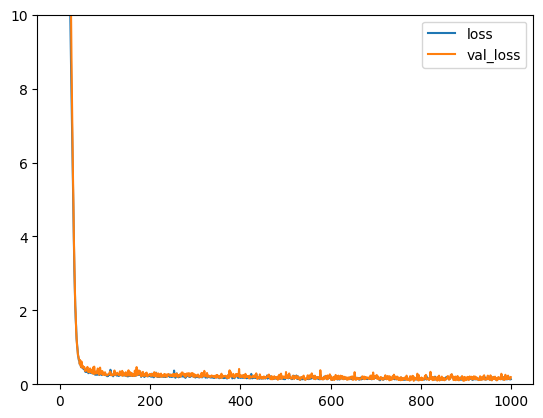

In [74]:
history = deep_net.fit(train_data,train_labels,
                      validation_split=0.2,verbose=0,epochs=1000)

histy = pd.DataFrame(history.history)
plt.plot(histy['loss'],label='loss')
plt.plot(histy['val_loss'],label='val_loss')
plt.legend()
plt.ylim(0,10)

In [84]:
SET=3

if SET == 1:
    test_data = data1.copy()
elif SET == 2:
    data = data2.copy()
    test_data = data.drop(train_data.index)
elif SET == 3:
    test_data = data3.copy()
else:
    raise Exception('Must define which dataset to use. (Num 1 to 3)')

test_labels = test_data[['01-A (mass number)','01-Z (atomic number)','01-q (ion charge)']]
for l in ['01-A (mass number)','01-Z (atomic number)','01-q (ion charge)']:
    test_data.pop(l)
print(test_data.shape, test_labels.shape)

test_data['vel'] = test_data['length']/test_data['tof']/1e-9
test_data['beta'] = test_data['vel']/3e8
test_data['gamma'] = np.sqrt(1/(1-test_data['beta']*test_data['beta']))
test_data['AoQ'] = test_data['02-Brho [T*m]'] / (3.1071*test_data['beta']*test_data['gamma'])

test_data['q'] = test_data['02-TKE [MeV]']/(test_data['gamma']-1)/(931.494013*test_data['AoQ'])
test_data['A'] = test_data['AoQ']*test_data['q']
test_data['Z-prime'] = np.sqrt(test_data['01-Energy Loss (MeV)']/np.log(5930/(1/test_data['beta']**2 - 1))*test_data['beta']**2)

test_data[:4]

(300, 7) (300, 3)


,01-X [mm],01-dP/P [%],01-Energy Loss (MeV),length,tof,02-Brho [T*m],02-TKE [MeV],vel,beta,gamma,AoQ,q,A,Z-prime
N,,,,,,,,,,,,,,
1,16.925180,0.522942,6214.135,46.04013,399.2964,3.492964,14591.97,1.153031e+08,0.384344,1.083201,2.700288,69.726407,188.281384,11.504857
2,7.669316,0.500030,6421.781,46.06817,397.4445,3.488030,15092.04,1.159110e+08,0.386370,1.084194,2.679876,71.807661,192.435611,11.746694
3,-18.371670,-0.695264,6499.333,46.06908,399.5629,3.472247,14976.02,1.152987e+08,0.384329,1.083193,2.684394,71.991534,193.253645,11.765526
4,8.287378,0.021447,6364.301,46.05051,399.1473,3.486575,14807.89,1.153722e+08,0.384574,1.083313,2.693455,70.841848,190.809354,11.648831


In [85]:
test_labels[:4]

,01-A (mass number),01-Z (atomic number),01-q (ion charge)
N,,,
1,189.0,72.0,70.0
2,193.0,74.0,72.0
3,193.0,74.0,72.0
4,191.0,73.0,71.0


In [86]:
deep_net.predict(test_data[:4])

1/1 [==============================] - 0s 31ms/step


array([[188.90376 ,  71.92232 ,  69.96555 ],
       [192.13148 ,  73.58547 ,  71.7086  ],
       [192.77829 ,  73.80863 ,  71.91576 ],
       [190.90808 ,  72.75838 ,  70.905556]], dtype=float32)

In [87]:
result = deep_net.evaluate(test_data,test_labels,verbose=1)
print(f"Mean Absolute Error: {result}")

10/10 [==============================] - 0s 2ms/step - loss: 0.1798
Mean Absolute Error: 0.17977407574653625


In [ ]:
plt.title('Original A (Red) vs New A (Blue)')
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.plot(hist1.history['accuracy'],'r',hist4.history['accuracy'])

In [ ]:
# loss1, acc1 = model1.evaluate(test_in,test_out[:,0],verbose=2)
# plt.title('Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Percent')
# plt.plot(hist1.history['accuracy'])

loss1, acc1 = model1.evaluate(test_in,test_out[:,0],verbose=2)
loss2, acc2 = model2.evaluate(test_in,test_out[:,1],verbose=2)
loss3, acc3 = model3.evaluate(test_in,test_out[:,2],verbose=2)

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.title('A vs Z')
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.plot(hist1.history['accuracy'],'r',hist2.history['accuracy'],'b')
plt.subplot(1,3,3)
plt.title('Long Run A')
plt.xlabel('Cycles')
plt.ylabel('Percent')
plt.plot(hist4.history['accuracy'],'r')
plt.subplot(1,3,2)
plt.title('A vs Q')
plt.xlabel('Cycles')
plt.ylabel('Accuracy')
plt.plot(hist1.history['accuracy'],'r',hist3.history['accuracy'],'g')

In [ ]:
prob = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = prob.predict(train_in)
predictions.shape

In [ ]:
listy=[]
for p in predictions:
    listy.append(np.argmax(p))
    
Z_out = np.array(listy)[...,None]
trained_Z = np.append(train_in,Z_out/max(Z_out)[0],1)

In [ ]:
trained_Z

In [ ]:
model1=[]
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(118)
])

model1.compile(optimizer=myopt,loss=myloss,metrics=['accuracy'])

In [ ]:
model1.fit(trained_Z,train_out[:,2],epochs=500)

In [ ]:
prob1 = tf.keras.Sequential([model1,tf.keras.layers.Softmax()])
predictions1 = prob1.predict(trained_Z)

listy=[]
for p in predictions1:
    listy.append(np.argmax(p))
    
Q_out = np.array(listy)[...,None]
trained_ZQ = np.append(trained_Z,Q_out/max(Q_out)[0],1)


In [ ]:
trained_ZQ[55],Z_out[55],Q_out[55],train_out[55]

In [ ]:
def plot_dat(i,prediction,actuals,Ptable):

    
    act = int(actuals[i][1])
    pred_label = np.argmax(prediction)
    
    if pred_label == act:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f"Guess: {Ptable[str(pred_label)][0]} Actual: {Ptable[str(act)][0]}, {Ptable[str(act)][1]}",color=color)
    plt.xticks([])
    plt.yticks([])
    
    barplt = plt.bar(range(len(prediction)),prediction,color='black')
    plt.ylim(0,1)
    
    barplt[pred_label].set_color('red')
    barplt[act].set_color('blue')

In [ ]:
plt.figure(figsize=(12,12))
col = 3
row = 3
for i in range(col*row):
    model.fit(train_in,train_out[:,1],epochs=50)
    prob = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
    predictions = prob.predict(test_in)
    plt.subplot(row,col,i+1)
    plot_dat(1,predictions[1],test_out,Ptable)
plt.show()

In [ ]:
prob = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = prob.predict(test_in)
plt.figure(figsize=(12,12))
col = 3
row = 3
for i in range(col*row):
    plt.subplot(row,col,i+1)
    plot_dat(i,predictions[i],test_out,Ptable)
plt.show()

In [ ]:
'''The final layer of nodes... It represents bins in which the NN is guessing at the answer.
Allowing for there to be three nodes at the end confuses this NN because we expect each node to correspond
to a A, Z, and Q respectively when it really corresponds to a value of 1,2,3 for a single label (Like A or something).
Do we need a convolution network to predict these three labels?
The reason we can rely on the weights on each node to represent the A,Z,Q values is because... For starters the weights
are normalized. Even if we normalized our output labels though, this issue we have here is a fundamental mismatch of how
we expect the NN to work and how it's coded.'''

'''I think one of the big challenges of this data is the mean vs the variance.
The mean is around 190 and the variance is probably around 1 or two ish.
What do we call data like this? And how to we better build our NN around this format?'''

'''An idea, feed the answers of one network into the next, 
the next network becomes inputs + 1 and predicts the next label...'''